In [60]:
# 1. INITIAL SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Haversine function for distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [61]:
# 2. DATA LOADING AND INITIAL INSPECTION (IMPROVED)
df = pd.read_csv('bike.csv', dtype={
    'start_station_id': str,  # Force as string
    'end_station_id': str     # Force as string
}, low_memory=False)

print("Initial data preview:")
print(df.head())

print("\nData structure:")
print(df.info())

print("\nDescriptive statistics:")
print(df.describe())

Initial data preview:
            ride_id rideable_type started_at ended_at  start_station_name  \
0  7FB44ACE772F2B5E  classic_bike    29:00.5  38:38.2  E 47 St & Park Ave   
1  514091422D32E0D4  classic_bike    49:13.1  23:30.1  Carmine St & 6 Ave   
2  C094CBA14014648D  classic_bike    54:03.7  05:19.0  Carmine St & 6 Ave   
3  6675D4453C4DBFE4  classic_bike    58:28.5  08:07.2  Carmine St & 6 Ave   
4  FE65CE25E01D48B7  classic_bike    19:43.3  29:40.9  Carmine St & 6 Ave   

  start_station_id         end_station_name end_station_id  start_lat  \
0          6584.12          5 Ave & E 63 St        6904.06  40.755103   
1          5763.03      Mott St & Prince St        5561.04  40.730386   
2          5763.03  Allen St & Rivington St        5414.06  40.730386   
3          5763.03  Allen St & Rivington St        5414.06  40.730386   
4          5763.03  Allen St & Rivington St        5414.06  40.730386   

   start_lng    end_lat    end_lng member_casual  
0 -73.974987  40.766368 -

In [62]:
# 1. DATA CLEANING
def clean_data(df):
    # Handle missing values
    print("\nMissing values before cleaning:")
    print(df.isnull().sum())
    df = df.dropna(subset=['started_at', 'ended_at', 'start_lat', 'start_lng', 'end_lat', 'end_lng'])
    
    # Convert time formats
    def convert_time(time_str):
        try:
            if ':' in time_str:
                parts = time_str.split(':')
                if len(parts) == 2:  # mm:ss format
                    return int(parts[0]) * 60 + float(parts[1])
                elif len(parts) == 3:  # hh:mm:ss format
                    return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
            return float(time_str)
        except:
            return np.nan
    
    df['started_at'] = df['started_at'].apply(convert_time)
    df['ended_at'] = df['ended_at'].apply(convert_time)
    
    # Calculate duration and filter outliers
    df['duration'] = df['ended_at'] - df['started_at']
    df = df[(df['duration'] > 60) & (df['duration'] < 3600*24)]
    
    # Calculate distance and filter outliers
    df['distance_km'] = df.apply(lambda x: haversine(x['start_lat'], x['start_lng'], 
                                                    x['end_lat'], x['end_lng']), axis=1)
    df = df[df['distance_km'] < 50]
    
    # Encode categorical variables
    df['member_casual'] = df['member_casual'].map({'member': 1, 'casual': 0})
    
    # Calculate speed and filter outliers
    df['speed_kmh'] = df['distance_km'] / (df['duration'] / 3600)
    df = df[(df['speed_kmh'] > 5) & (df['speed_kmh'] < 30)]
    
    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    
    return df

cleaned_df = clean_data(df)
print("\nCleaning complete. Final shape:", cleaned_df.shape)


Missing values before cleaning:
ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name      344
end_station_id        344
start_lat               0
start_lng               0
end_lat               344
end_lng               344
member_casual           0
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_4116\3400064902.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = df['started_at'].apply(convert_time)
C:\Users\USER\AppData\Local\Temp\ipykernel_4116\3400064902.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = df['ended_at'].apply(convert_time)
C:\Users\USER\AppData\Local\Temp\ipykernel_4116\3400064902.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind


Missing values after cleaning:
ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
duration              0
distance_km           0
speed_kmh             0
dtype: int64

Cleaning complete. Final shape: (54365, 16)



Descriptive Statistics:
           duration   distance_km     speed_kmh
count  54365.000000  54365.000000  54365.000000
mean     576.954677      1.555092      9.923762
std      402.691324      1.141579      2.438280
min       60.700000      0.107941      5.000076
25%      293.700000      0.785026      8.199701
50%      467.000000      1.232430      9.747105
75%      736.400000      1.952205     11.439511
max     3295.700000     13.781107     29.205241


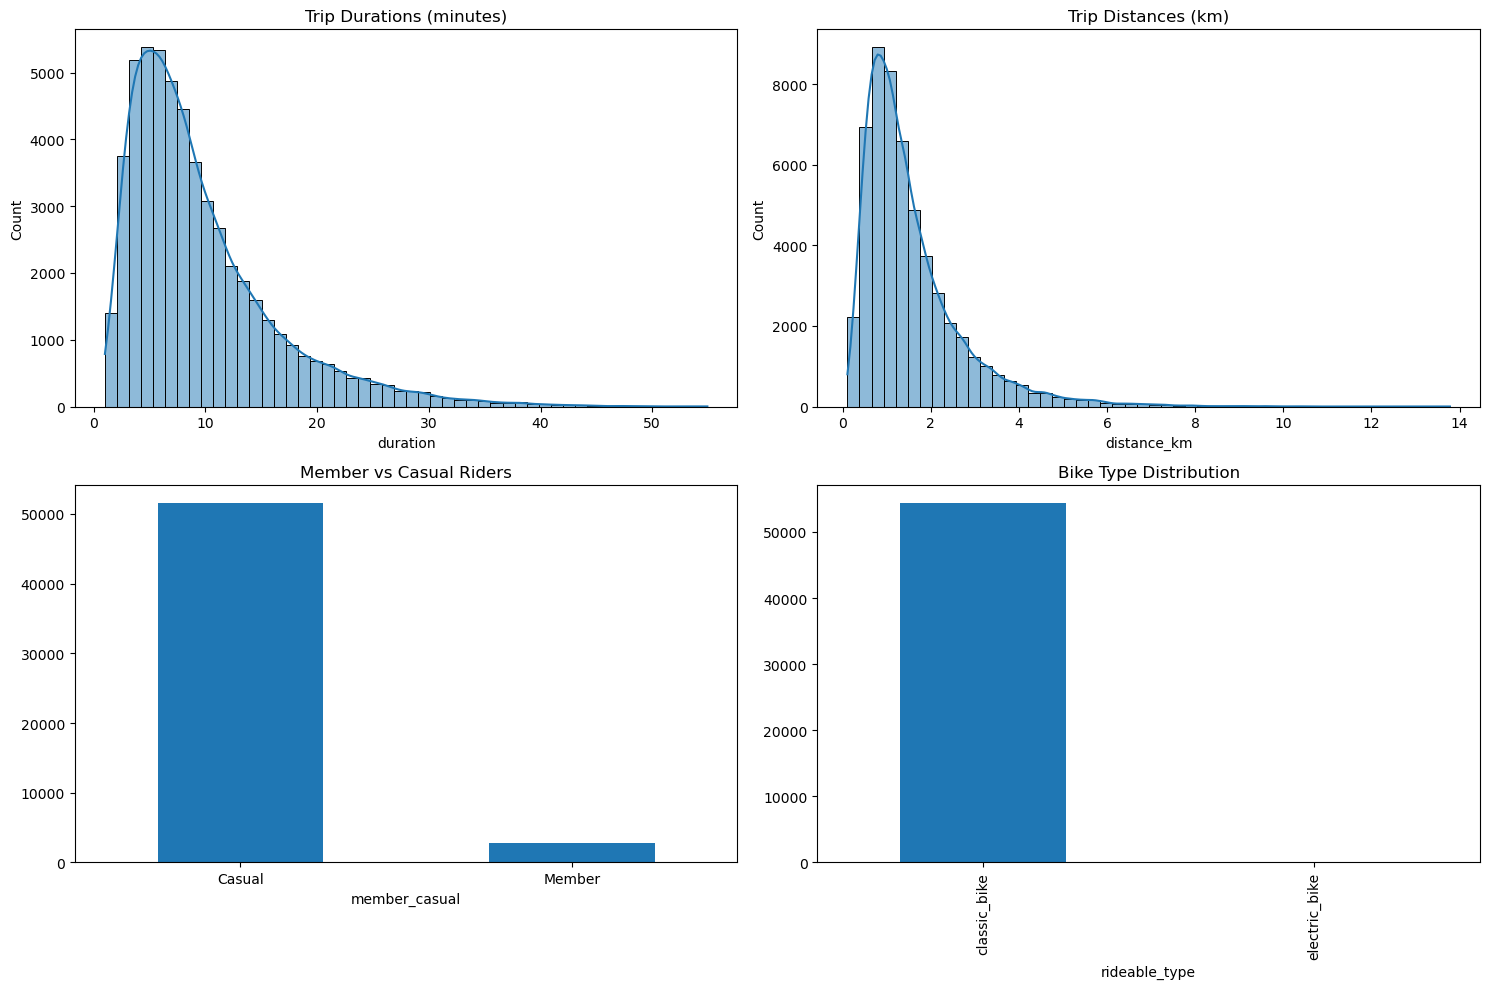

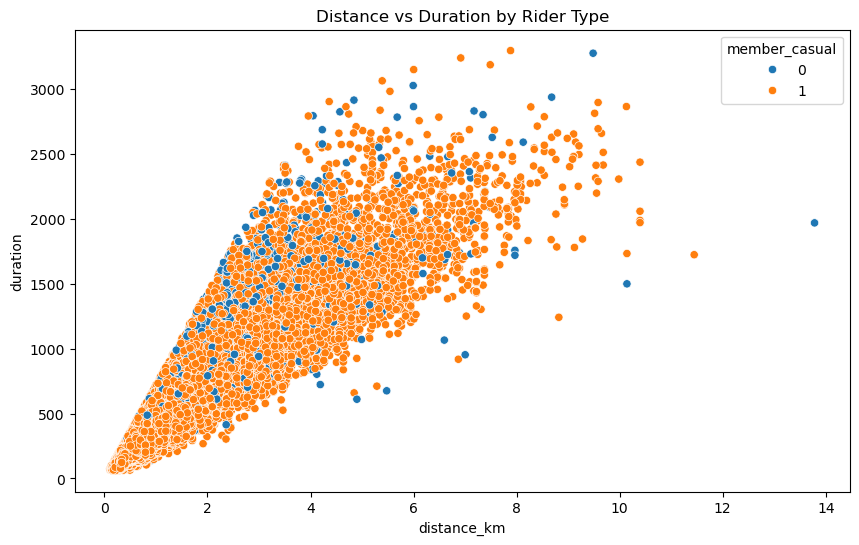


Average Metrics by Rider Type:
                 duration  distance_km  speed_kmh
member_casual                                    
0              853.466080     2.026734   8.918132
1              561.702354     1.529076   9.979233


In [63]:
# 2 EXPLORATORY DATA ANALYSIS (EDA)
def perform_eda(df):
    # Descriptive statistics
    print("\nDescriptive Statistics:")
    print(df[['duration', 'distance_km', 'speed_kmh']].describe())
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Duration distribution
    plt.subplot(2, 2, 1)
    sns.histplot(df['duration']/60, bins=50, kde=True)
    plt.title('Trip Durations (minutes)')
    
    # Distance distribution
    plt.subplot(2, 2, 2)
    sns.histplot(df['distance_km'], bins=50, kde=True)
    plt.title('Trip Distances (km)')
    
    # Rider type distribution
    plt.subplot(2, 2, 3)
    df['member_casual'].value_counts().plot(kind='bar')
    plt.title('Member vs Casual Riders')
    plt.xticks([0, 1], ['Casual', 'Member'], rotation=0)
    
    # Bike type distribution
    plt.subplot(2, 2, 4)
    df['rideable_type'].value_counts().plot(kind='bar')
    plt.title('Bike Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Relationship analysis
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='distance_km', y='duration', hue='member_casual', data=df)
    plt.title('Distance vs Duration by Rider Type')
    plt.show()
    
    # Group comparisons
    print("\nAverage Metrics by Rider Type:")
    print(df.groupby('member_casual').agg({
        'duration': 'mean',
        'distance_km': 'mean',
        'speed_kmh': 'mean'
    }))

perform_eda(cleaned_df)


Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.10      0.17       837
           1       0.95      0.99      0.97     15473

    accuracy                           0.95     16310
   macro avg       0.72      0.55      0.57     16310
weighted avg       0.93      0.95      0.93     16310


Accuracy Score: 0.9483139178418148


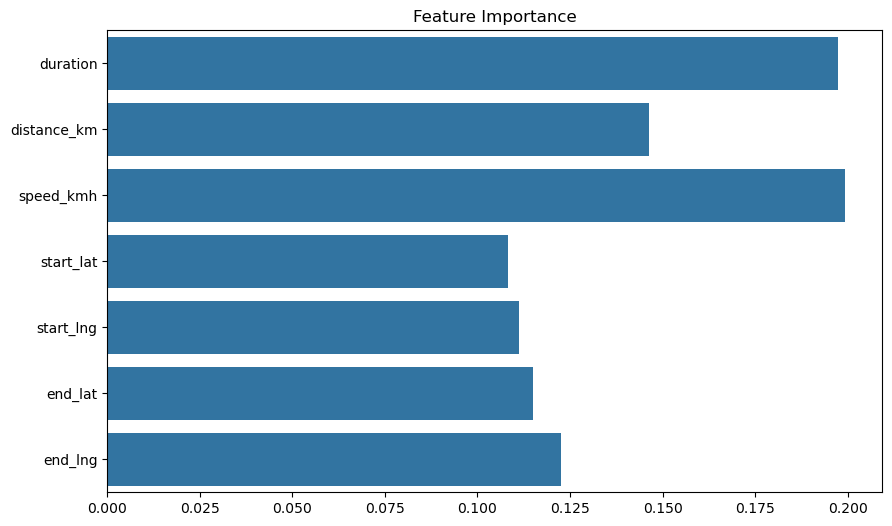

In [64]:
# 3 CLASSIFICATION MODEL (Member vs Casual Prediction)
# Prepare data
def prepare_data(df):
    features = ['duration', 'distance_km', 'speed_kmh', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
    X = df[features]
    y = df['member_casual']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(cleaned_df)

# Train model
def train_classification_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

model = train_classification_model(X_train, y_train)

# Evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
    
    features = ['duration', 'distance_km', 'speed_kmh', 'start_lat', 'start_lng', 'end_lat', 'end_lng']
    importances = model.feature_importances_
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances, y=features)
    plt.title('Feature Importance')
    plt.show()

evaluate_model(model, X_test, y_test)

For n_clusters = 2, silhouette score is 0.4828423299163157
For n_clusters = 3, silhouette score is 0.3595214194945267
For n_clusters = 4, silhouette score is 0.36330665133493006
For n_clusters = 5, silhouette score is 0.31923258906387303
For n_clusters = 6, silhouette score is 0.32596174418642887

Optimal number of clusters: 2 with score 0.4828423299163157


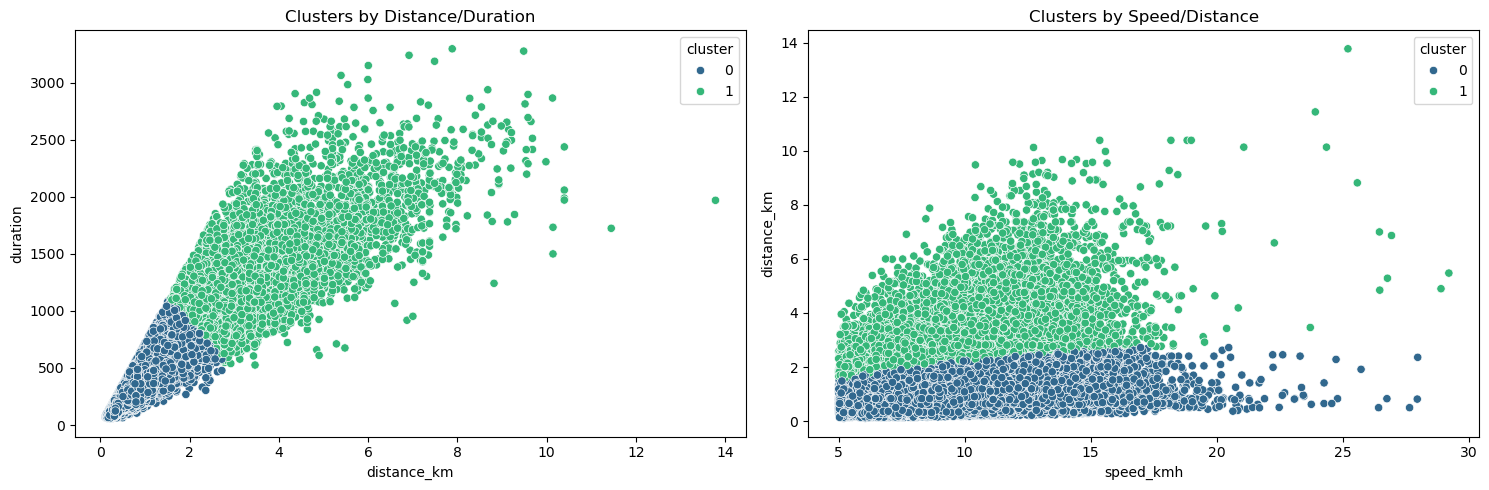


Cluster Characteristics:
            duration  distance_km  speed_kmh  member_casual
cluster                                                    
0         417.399094     1.107561   9.869395       0.960362
1        1215.323779     3.345628  10.141279       0.897158


In [65]:
# CLUSTERING ANALYSIS
def perform_clustering(df):
    # 6.1 Prepare data
    features = ['duration', 'distance_km', 'speed_kmh']
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal clusters
    range_n_clusters = [2, 3, 4, 5, 6]
    best_score = -1
    best_n = 2
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg}")
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_n = n_clusters
    
    print(f"\nOptimal number of clusters: {best_n} with score {best_score}")
    
    # Final clustering
    kmeans = KMeans(n_clusters=best_n, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Visualize clusters
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='distance_km', y='duration', hue='cluster', data=df, palette='viridis')
    plt.title('Clusters by Distance/Duration')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='speed_kmh', y='distance_km', hue='cluster', data=df, palette='viridis')
    plt.title('Clusters by Speed/Distance')
    
    plt.tight_layout()
    plt.show()
    
    # Cluster analysis
    print("\nCluster Characteristics:")
    print(df.groupby('cluster').agg({
        'duration': 'mean',
        'distance_km': 'mean',
        'speed_kmh': 'mean',
        'member_casual': 'mean'
    }))
    
    return df

clustered_df = perform_clustering(cleaned_df)


Trip Purposes by Rider Type:
member_casual        0      1
inferred_purpose             
CBD arrival        280   4254
CBD circulation    423  10380
CBD departure      427   5915
Non-CBD trip      1712  30974


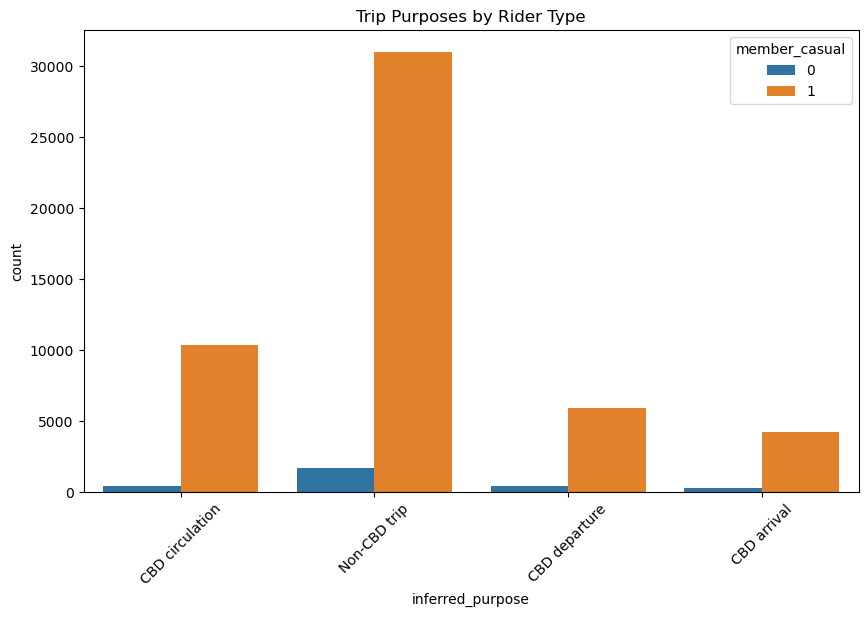

In [66]:
# 6. INNOVATIVE ANALYSIS: TRIP PURPOSE INFERENCE
def infer_trip_purposes(df):
    # Calculate CBD distances
    times_square_lat, times_square_lon = 40.7580, -73.9855
    
    df['start_dist_to_cbd'] = df.apply(
        lambda x: haversine(x['start_lat'], x['start_lng'], times_square_lat, times_square_lon), axis=1)
    df['end_dist_to_cbd'] = df.apply(
        lambda x: haversine(x['end_lat'], x['end_lng'], times_square_lat, times_square_lon), axis=1)
    
    # Infer purposes
    conditions = [
        (df['start_dist_to_cbd'] < 2) & (df['end_dist_to_cbd'] < 2),
        (df['start_dist_to_cbd'] < 2) & (df['end_dist_to_cbd'] >= 2),
        (df['start_dist_to_cbd'] >= 2) & (df['end_dist_to_cbd'] < 2),
        (df['start_dist_to_cbd'] >= 2) & (df['end_dist_to_cbd'] >= 2)
    ]
    
    choices = ['CBD circulation', 'CBD departure', 'CBD arrival', 'Non-CBD trip']
    df['inferred_purpose'] = np.select(conditions, choices)
    
    # Analyze purposes
    print("\nTrip Purposes by Rider Type:")
    print(pd.crosstab(df['inferred_purpose'], df['member_casual']))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    sns.countplot(x='inferred_purpose', hue='member_casual', data=df)
    plt.title('Trip Purposes by Rider Type')
    plt.xticks(rotation=45)
    plt.show()
    
    return df

cleaned_df = infer_trip_purposes(cleaned_df)